In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import metrics

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dhrub\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\dhrub\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
obj=metrics.metrics_calculate(start='2000-01-01',end='2025-12-31')
metrics_vader, metrics_lr, metrics_finbert, metrics_hold,df_vader_results,df_lr_results,df_finbert_results,df_hold_results=obj.calculate()

Downloaded 6538 days of price data
Loading news data from apple_news_data.csv...
Loaded 29752 news articles for AAPL
Combined dataset shape: (1133, 7)
Date range: 2016-02-19 to 2024-11-27


FinBERT inference: 100%|███████████████████████████████████████████████████████████| 1133/1133 [03:05<00:00,  6.11it/s]



STRATEGY PERFORMANCE COMPARISON
                     total_return  annual_return  annual_volatility  \
VADER                      324.18          12.04               0.47   
Logistic Regression        542.58          15.76               0.47   
FinBERT                    202.92           9.11               0.31   
holding                    972.06          20.51               0.49   

                     sharpe_ratio  max_drawdown  win_rate  
VADER                        0.89        -38.72     43.73  
Logistic Regression          1.08        -44.46     41.25  
FinBERT                      0.95        -34.72     36.84  
holding                      1.29        -35.94     53.45  


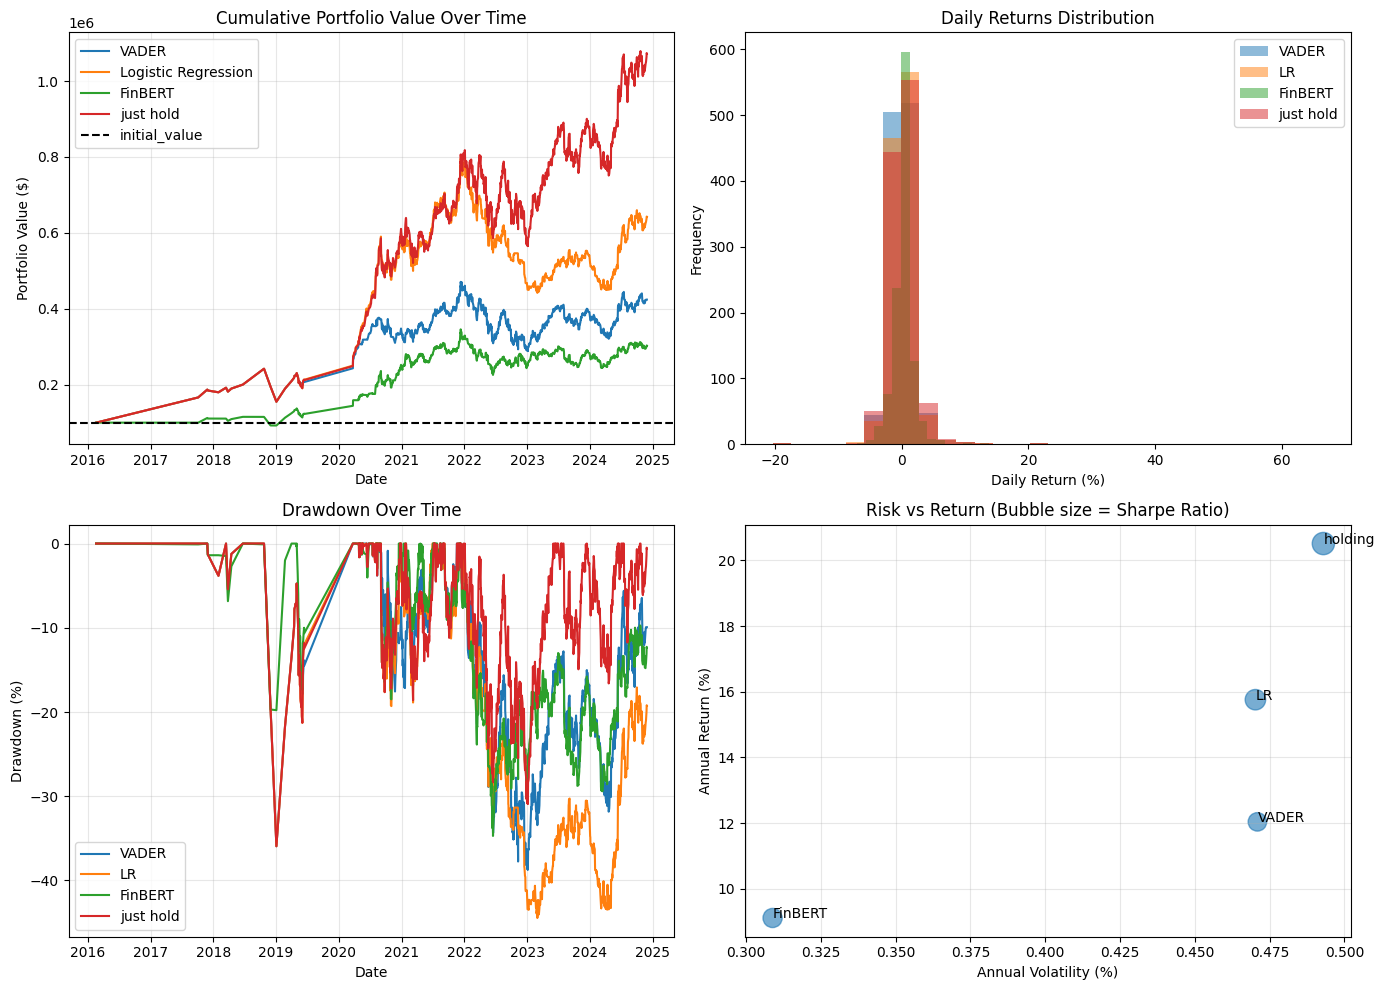

In [10]:


# Create comparison table
comparison_data = {
    'VADER': metrics_vader,
    'Logistic Regression': metrics_lr,
    'FinBERT': metrics_finbert,
    'holding': metrics_hold
}

df_comparison = pd.DataFrame(comparison_data).T

print("\nSTRATEGY PERFORMANCE COMPARISON")
print("="*80)
print(df_comparison[['total_return', 'annual_return', 'annual_volatility', 
                     'sharpe_ratio', 'max_drawdown', 'win_rate']].round(2))

# Example output:
# STRATEGY PERFORMANCE COMPARISON
# ════════════════════════════════════════════════════════════════════════════════════
#                        total_return  annual_return  annual_volatility  sharpe_ratio  max_drawdown  win_rate
# ─────────────────────────────────────────────────────────────────────────────────────────────────────────
# VADER                          12.45         24.90             14.56         1.71         -7.23     55.23
# Logistic Regression            18.67         37.34             18.92         1.97         -9.45     58.67
# FinBERT                        24.89         49.78             19.23         2.59        -11.34     62.45

# Visualize cumulative returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative returns
axes[0, 0].plot(df_vader_results['date'], df_vader_results['portfolio_value'], label='VADER')
axes[0, 0].plot(df_lr_results['date'], df_lr_results['portfolio_value'], label='Logistic Regression')
axes[0, 0].plot(df_finbert_results['date'], df_finbert_results['portfolio_value'], label='FinBERT')
axes[0, 0].plot(df_hold_results['date'], df_hold_results['portfolio_value'], label='just hold')
axes[0, 0].axhline(y=100000, color='black', linestyle='--', label='initial_value')
axes[0, 0].set_title('Cumulative Portfolio Value Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Portfolio Value ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Returns distribution
axes[0, 1].hist(df_vader_results['portfolio_value'].pct_change().dropna() * 100, bins=30, alpha=0.5, label='VADER')
axes[0, 1].hist(df_lr_results['portfolio_value'].pct_change().dropna() * 100, bins=30, alpha=0.5, label='LR')
axes[0, 1].hist(df_finbert_results['portfolio_value'].pct_change().dropna() * 100, bins=30, alpha=0.5, label='FinBERT')
axes[0, 1].hist(df_hold_results['portfolio_value'].pct_change().dropna() * 100, bins=30, alpha=0.5, label='just hold')
axes[0, 1].set_title('Daily Returns Distribution')
axes[0, 1].set_xlabel('Daily Return (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Plot 3: Drawdown analysis
def calculate_drawdown(portfolio_values):
    cummax = portfolio_values.expanding().max()
    drawdown = (portfolio_values - cummax) / cummax * 100
    return drawdown

axes[1, 0].plot(df_vader_results['date'], calculate_drawdown(df_vader_results['portfolio_value']), label='VADER')
axes[1, 0].plot(df_lr_results['date'], calculate_drawdown(df_lr_results['portfolio_value']), label='LR')
axes[1, 0].plot(df_finbert_results['date'], calculate_drawdown(df_finbert_results['portfolio_value']), label='FinBERT')
axes[1, 0].plot(df_hold_results['date'], calculate_drawdown(df_hold_results['portfolio_value']), label='just hold')
axes[1, 0].set_title('Drawdown Over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Drawdown (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Risk vs Return scatter
methods = ['VADER', 'LR', 'FinBERT','holding']
returns = [metrics_vader['annual_return'], metrics_lr['annual_return'], metrics_finbert['annual_return'],metrics_hold['annual_return']]
volatilities = [metrics_vader['annual_volatility'], metrics_lr['annual_volatility'], metrics_finbert['annual_volatility'],metrics_hold['annual_volatility']]
sharpes = [metrics_vader['sharpe_ratio'], metrics_lr['sharpe_ratio'], metrics_finbert['sharpe_ratio'],metrics_hold['sharpe_ratio']]

scatter = axes[1, 1].scatter(volatilities, returns, s=[s*200 for s in sharpes], alpha=0.6)
for i, method in enumerate(methods):
    axes[1, 1].annotate(method, (volatilities[i], returns[i]))
axes[1, 1].set_xlabel('Annual Volatility (%)')
axes[1, 1].set_ylabel('Annual Return (%)')
axes[1, 1].set_title('Risk vs Return (Bubble size = Sharpe Ratio)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()